# CESM-LE analysis template
 - analysis should be performed on Casper
 - works with either CESM1 or CESM2 (only historical at this point)
 - daniel kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [45]:
## was working with 16.2
xr.__version__

'0.16.2'

In [44]:
## was working with 2020.12.0
dask.__version__

'2020.12.0'

### run this cell to check if you have LENS2 read access:

In [43]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [4]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [48]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

Client Scheduler: tcp://10.12.205.27:43267 Dashboard: http://10.12.205.27:8787/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


### Some helpful functions:
 - run all these before proceeding to the 'start here' area:
 - you can certainly edit these, but shouldn't need to

In [6]:
def get_file(ee,model,field,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        firstyear = 10*int(yr/10)
        yy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'
        if yr>2009:
            yy = '.201001-201412.'
        ff     = glob.glob(mm+lnd+'*.h0.'+field+yy+'*')[0]
    return ff

In [7]:
def all_files(model,field,firstyear):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        nens = 42
        files = [get_file(ee,'CESM1',field,0) for ee in range(nens)]
    else:
        nens = 50
        yrs = [*np.arange(firstyear,2009,10),2010]
        files = [[get_file(ee,'CESM2',field,yr) for yr in yrs] 
                 for ee in range(nens)]
    return files

In [8]:
def get_monthly(model,fields,firstyear):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                ds = xr.open_mfdataset(files[0],combine='by_coords',parallel=True)
                tmp = xr.open_dataset(files[0][0])
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0])

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model])
        ds[field] = tmp[field]

    ds['landarea'] = ds['area']*ds['landfrac']
    ds['landarea'].name = 'landarea'
    ds['landarea'].attrs['units'] = 'km2'
        
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [56]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [57]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### read in the data:
 - the less data you take, the faster this will run

In [79]:
%%time
model = 'CESM2'
fields = ['GPP','TWS']  # always brackets, fields = ['GPP']
firstyear = 1850
ds = get_monthly(model,fields,firstyear)

CPU times: user 1min 12s, sys: 15 s, total: 1min 27s
Wall time: 1min 31s


## sample analyses:

### global annual GPP

In [82]:
#compute annual total GPP
nyears  = len(np.unique(ds['time.year']))
cf = 24*60*60           # used to convert /s to /d
dpm = month_wts(nyears) # days per month
gpp_ann = cf*(dpm*ds.GPP).groupby('time.year').sum(skipna=True) # gridded annual total gpp

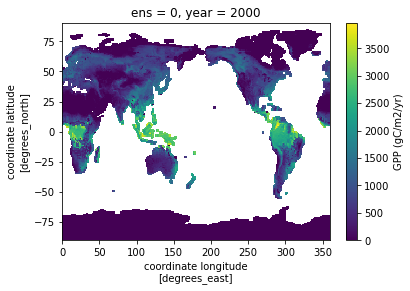

In [84]:
# plot one year from one ensemble member
#   where statement masks the ocean
gpp_ann.sel(ens=0,year=2000).where(ds.landarea>0).plot(cbar_kwargs={'label':'GPP (gC/m2/yr)'});

In [85]:
# sum across gridcells, weighting by landarea
cf1 = 1e6    #km2-->m2
cf2 = 1e-15  #gC-->PgC and kgH2O-->TtH2O
gpp_ann_glob = cf1*cf2*(ds.landarea*gpp_ann).sum(dim=['lat','lon'])

In [86]:
%%time
##  force the calculation:
##     xarray uses lazy evaluation, avoiding crunching the numbers 
##     up to this point, I haven't actually done any calculations!
##     xarray waits until I explicitly require it to do so
##     best to do this ahead of plotting for big calculations
##  Note that if you plan on reusing an intermediate result:
##     e.g. annual averages, 
##     you should probably force the calc and save it at that step
##  If you see files like core-casper25- appearing, you have an issue
gpp_ann_glob = gpp_ann_glob.compute()

CPU times: user 1min 38s, sys: 1.73 s, total: 1min 40s
Wall time: 1min 42s


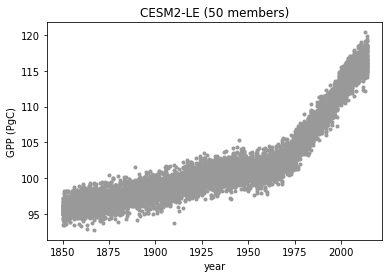

In [87]:
t = np.unique(ds['time.year'])
plt.plot(t,gpp_ann_glob,'.',color=[0.6,0.6,0.6])
plt.xlabel('year')
plt.ylabel('GPP (PgC)')
plt.title('CESM2-LE (50 members)');